<a href="https://colab.research.google.com/github/Pineappledeydre/gas_emission_prediction/blob/main/gas_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
import os
os.kill(os.getpid(), 9)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_model = pd.read_csv('/content/Complex_Emission_Dataset.csv')

df_model.head()

,date,site_id,temp,pressure,humidity,load,maintenance_flag,gas_type,operational_hours,emission
0,2024-01-01,Site_1,8.856544,1028.336947,29.361118,49.359671,0,CH4,20,353.168599
1,2024-01-02,Site_1,9.455275,1022.359435,30.909498,51.004271,0,CH4,20,347.951985
2,2024-01-03,Site_1,-3.006487,1022.080995,56.711174,48.369632,0,CH4,22,349.629342
3,2024-01-04,Site_1,4.489220,1023.970442,55.544874,42.787025,0,CO2,16,350.399720
4,2024-01-05,Site_1,2.614908,1022.892776,61.053982,66.409150,0,CO2,23,367.091204


In [ ]:
df_model.describe()

,temp,pressure,humidity,load,maintenance_flag,operational_hours,emission
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,7.075802,1016.473132,49.573846,70.053491,0.042192,19.478356,354.945658
std,6.709063,5.067646,17.221331,17.324330,0.201082,2.276573,9.144831
min,-13.098987,1003.476590,20.039203,40.013622,0.000000,16.000000,327.800757
25%,2.277381,1012.788582,34.608938,55.648506,0.000000,17.000000,348.462010
50%,7.051323,1015.825116,49.091524,69.662249,0.000000,20.000000,354.951321
75%,11.618163,1019.729919,64.958921,85.179172,0.000000,21.000000,361.616276
max,26.814670,1035.326052,79.961018,99.973462,1.000000,23.000000,378.719061


In [ ]:
le_site = LabelEncoder()
le_gas = LabelEncoder()
df_model['site_id'] = le_site.fit_transform(df_model['site_id'])
df_model['gas_type'] = le_gas.fit_transform(df_model['gas_type'])

# Разделение на признаки и целевую переменную
features = ['site_id', 'temp', 'pressure', 'humidity', 'load',
            'maintenance_flag', 'gas_type', 'operational_hours']
target = 'emission'

X = df_model[features]
y = df_model[target]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoost
cat_model = CatBoostRegressor(verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Метрики
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }


In [ ]:
import joblib

model_path = "/content/cat_model.pkl"
joblib.dump(cat_model, model_path)

model_path


'/content/cat_model.pkl'

<ipython-input-9-866c25e441f8>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




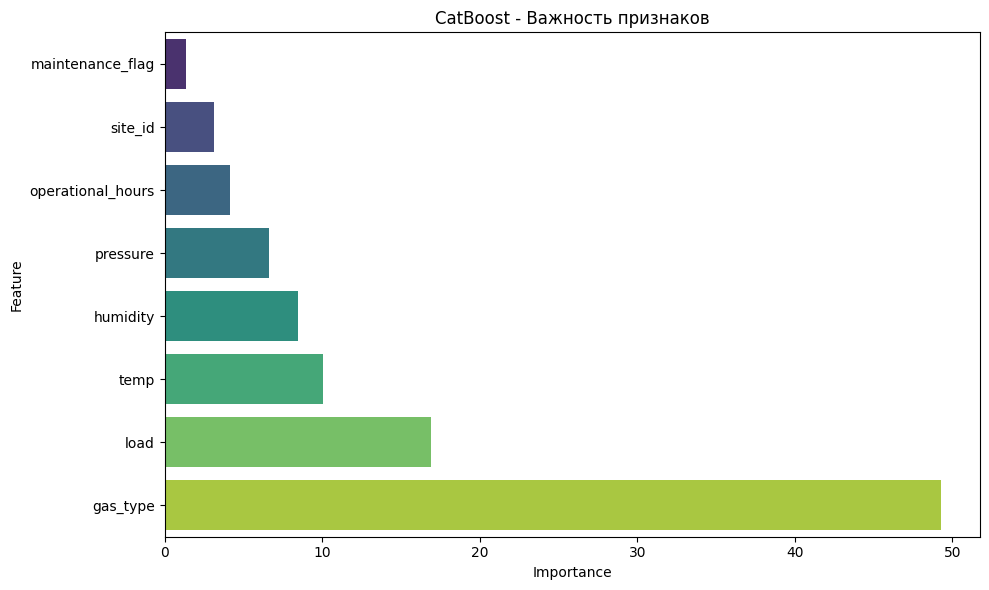

In [ ]:
results = [
    evaluate_model("CatBoost", y_test, cat_preds),
    evaluate_model("XGBoost", y_test, xgb_preds)
]

metrics_df = pd.DataFrame(results)

# Визуализация важности признаков для CatBoost
feature_importance = cat_model.get_feature_importance(Pool(X_train, y_train))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df.sort_values(by='Importance', ascending=True, inplace=True)

# Построение графиков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("CatBoost - Важность признаков")
plt.tight_layout()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Подготовим словарь для хранения моделей и метрик по site_id
lstm_models = {}
lstm_metrics = {}

# Для каждого site_id обучим отдельную LSTM модель
for site in df_model['site_id'].unique():
    site_data = df_model[df_model['site_id'] == site].sort_values(by='date')
    emissions = site_data[['emission']].values

    # Масштабируем данные
    scaler = MinMaxScaler()
    emissions_scaled = scaler.fit_transform(emissions)

    # Формируем X и y для LSTM
    X_lstm, y_lstm = [], []
    for i in range(10, len(emissions_scaled)):
        X_lstm.append(emissions_scaled[i-10:i, 0])
        y_lstm.append(emissions_scaled[i, 0])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    # Модель LSTM
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_lstm, y_lstm, epochs=20, verbose=0)

    # Предсказания и обратное масштабирование
    preds_scaled = model.predict(X_lstm)
    preds = scaler.inverse_transform(preds_scaled)
    true_vals = scaler.inverse_transform(y_lstm.reshape(-1, 1))

    # Сохраняем модель и метрики
    lstm_models[site] = model
    lstm_metrics[f'Site_{site}'] = {
        'MAE': mean_absolute_error(true_vals, preds),
        'RMSE': np.sqrt(mean_squared_error(true_vals, preds)),
        'R2': r2_score(true_vals, preds)
    }

# Преобразуем метрики в DataFrame
lstm_metrics_df = pd.DataFrame.from_dict(lstm_metrics, orient='index')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
